In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
from scipy import stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results

import conf.isi5_mouse as cfg

In [2]:
nspikes = get_digest_output(cfg, 'nspikes')
histograms = get_digest_output(cfg, 'histograms')

In [3]:
q = dict(STD=0, TA=1, isi=500)
idx = ii.getindex(cfg, **q)[:-1]

In [4]:
response = {}
response['std'] = nspikes['std'][idx].sum(-1).mean((0,-1))
response['dev'] = nspikes['dev'][idx].sum(-1).mean((0,-1))
response['msc'] = nspikes['msc'][idx].sum(-1).mean((0,-1))

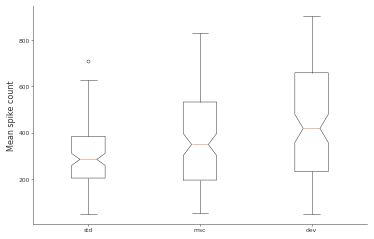

In [5]:
conds = ('std', 'msc', 'dev')
R = [response[cond].flatten() for cond in conds]
plt.boxplot(R, True)
plt.xticks(np.arange(len(conds))+1, conds)
plt.ylabel('Mean spike count')
sns.despine()

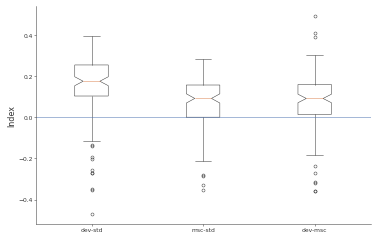

In [6]:
R = []
labels = []
for c0, c1 in (('dev','std'), ('msc','std'), ('dev','msc')):
    r0, r1 = [response[c] for c in (c0, c1)]
    R.append((r0-r1)/(r0+r1))
    labels.append(f'{c0}-{c1}')
plt.boxplot([r.ravel() for r in R], True)
plt.xticks(np.arange(len(labels))+1, labels)
plt.ylabel('Index')
plt.axhline(0)
sns.despine()

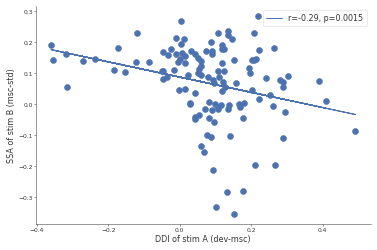

In [7]:
Bssa = np.flip(R[1], 2).flatten()
ddi = R[2].flatten()
plt.scatter(ddi, Bssa)
regression = stats.linregress(ddi, Bssa)
plt.plot(ddi, regression.intercept + ddi*regression.slope, lw=1,
         label=f'r={regression.rvalue:.2g}, p={regression.pvalue:.2g}')
plt.legend()
plt.xlabel('DDI of stim A (dev-msc)')
plt.ylabel('SSA of stim B (msc-std)')
sns.despine()

The more a standard (B) response is reduced in the oddball protocol, the less the corresponding deviant (A) increases? That doesn't make much sense.

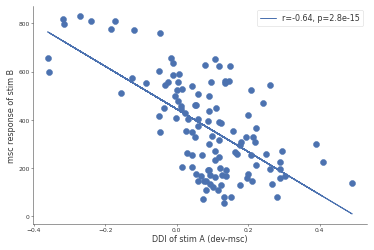

In [8]:
Bmsc = np.flip(response['msc'], 2).flatten()
ddi = R[2].flatten()
plt.scatter(ddi, Bmsc)
regression = stats.linregress(ddi, Bmsc)
plt.plot(ddi, regression.intercept + ddi*regression.slope, lw=1,
         label=f'r={regression.rvalue:.2g}, p={regression.pvalue:.2g}')
plt.legend()
plt.xlabel('DDI of stim A (dev-msc)')
plt.ylabel('msc response of stim B')
sns.despine()

The higher the default response of standard (B), the less the corresponding deviant (A) increases. That makes a lot of sense!

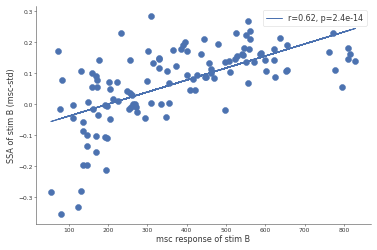

In [9]:
plt.scatter(Bmsc, Bssa)
regression = stats.linregress(Bmsc, Bssa)
plt.plot(Bmsc, regression.intercept + Bmsc*regression.slope, lw=1,
         label=f'r={regression.rvalue:.2g}, p={regression.pvalue:.2g}')
plt.legend()
plt.xlabel('msc response of stim B')
plt.ylabel('SSA of stim B (msc-std)')
sns.despine()

The higher the default (msc) response, the more it shrinks in standard. This explains the first plot: A higher opponent response is related both to higher opponent SSA and to lower target DDI.

Let's find a pair that:
- has average A control response size
- has average B control response size
- looks similar to culture (dev >> msc > std)
- has higher DDI with STD than without

In [10]:
q2 = {**q, 'STD': 1}
idx2 = ii.getindex(cfg, **q2)[:-1]

In [11]:
response2 = {}
response2['std'] = nspikes['std'][idx2].sum(-1).mean((0,-1))
response2['dev'] = nspikes['dev'][idx2].sum(-1).mean((0,-1))
response2['msc'] = nspikes['msc'][idx2].sum(-1).mean((0,-1))

r0, r1 = [response[c] for c in ('dev', 'msc')]
ddi = (r0-r1)/(r0+r1)
r0, r1 = [response2[c] for c in ('dev', 'msc')]
ddi2 = (r0-r1)/(r0+r1)

In [12]:
# Scores - lower is better
zA = np.abs(stats.zscore(response2['msc'].flatten()))
zB = np.flip(zA.reshape(response2['msc'].shape), 2).flatten()
ddiff = (ddi-ddi2).flatten()

In [13]:
preselection = (zA<1) & (zB<1) & (ddiff<np.median(ddiff))
preselection.sum(), np.median(ddiff)

(27, -0.03117010202493081)

In [14]:
numbers = [(net, pair, stim) for net in range(cfg.N_networks) for pair in range(2) for stim in range(2)]

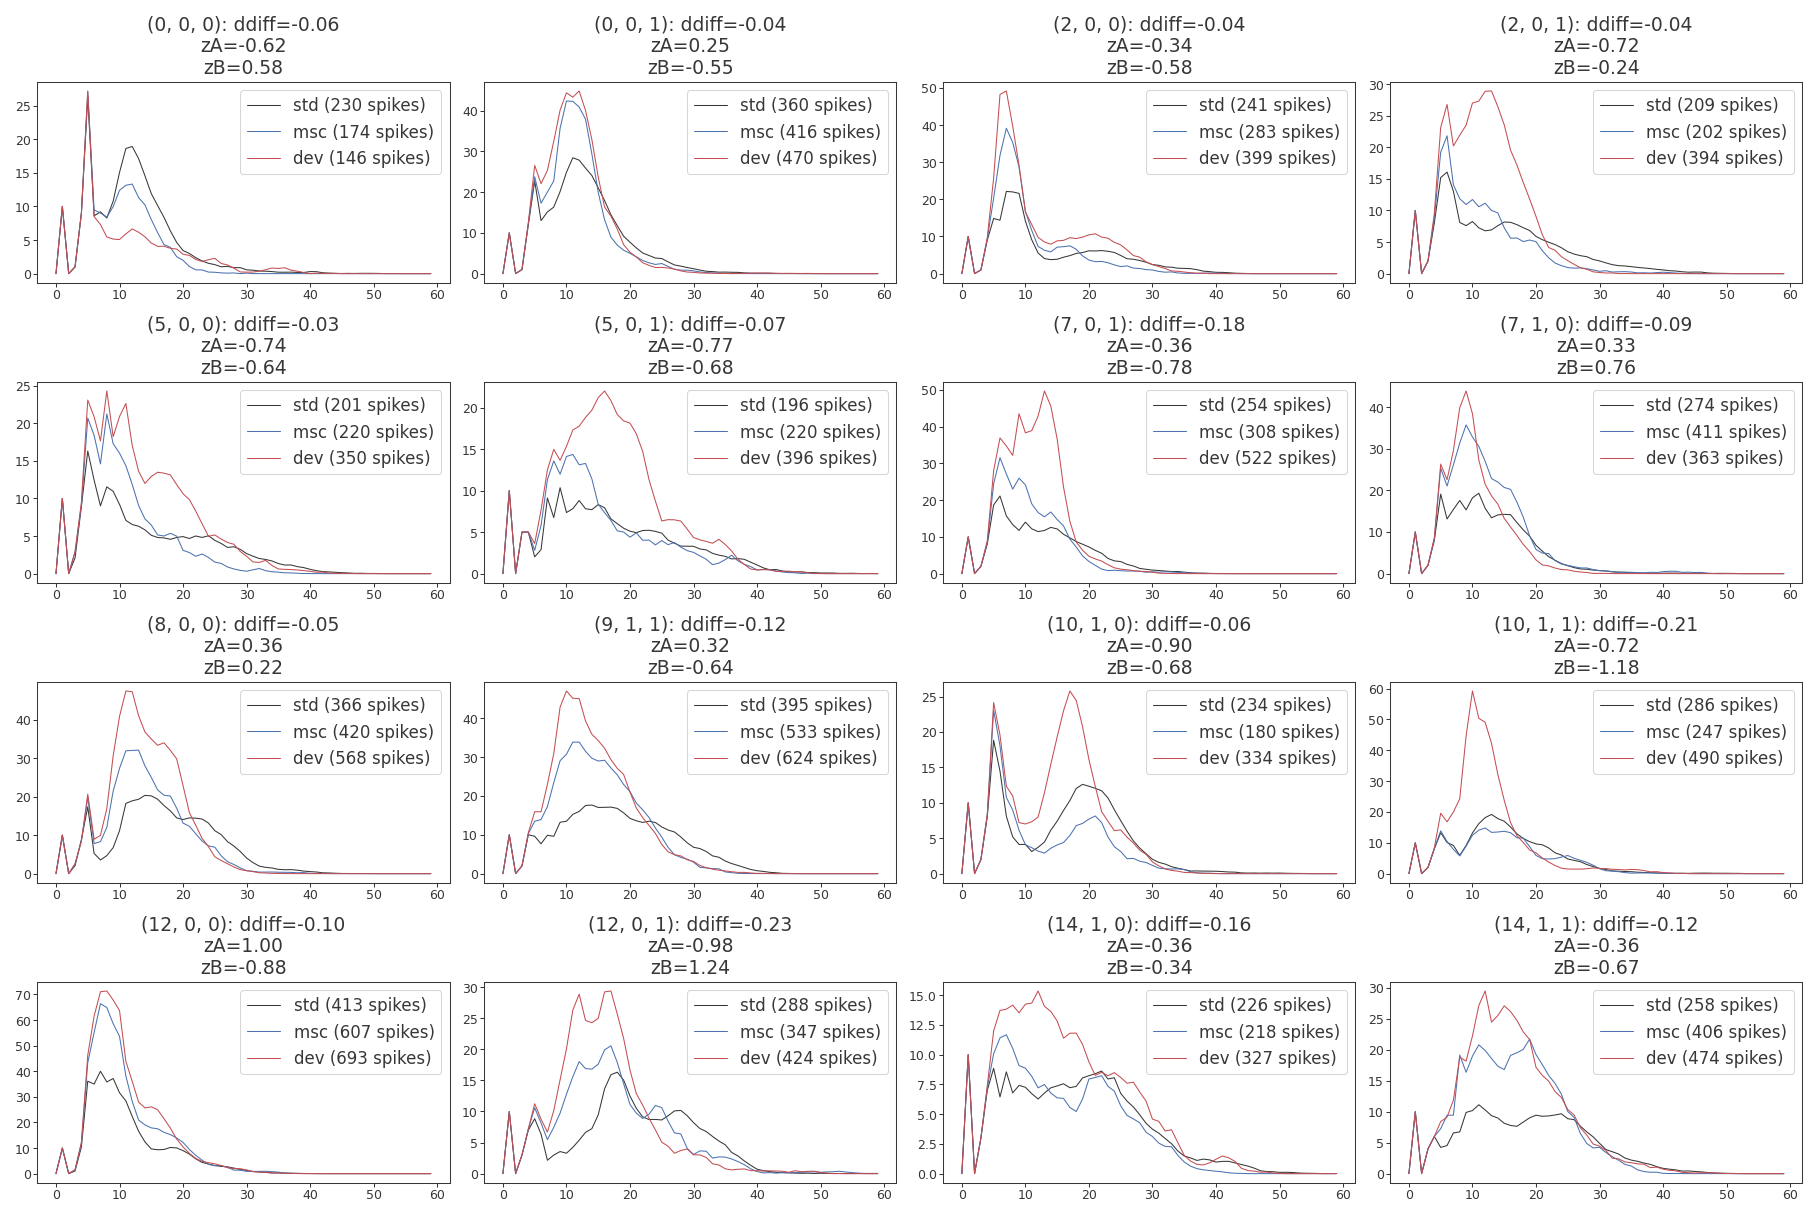

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(12,8), layout='constrained', dpi=150)
tmax = 60
for k, ax in zip(np.flatnonzero(preselection), axs.flatten()):
    for cond in conds:
        pspike = histograms['pspike'][ii.getindex(cfg, **q, templ=0, cond=cond)].sum(-2).reshape(len(preselection), -1)[k, :tmax]
        ax.plot(pspike, color=pu.colors[cond], label=f'{cond} ({pspike.sum():.0f} spikes)')
    ax.legend()

    ax.set_title(f'{numbers[k]}: ddiff={ddiff[k]:.2f}\n'
                 f'zA={stats.zscore(response2["msc"].flatten()).flatten()[k]:.2f}\n'
                 f'zB={stats.zscore(np.flip(response2["msc"],2)).flatten()[k]:.2f}')

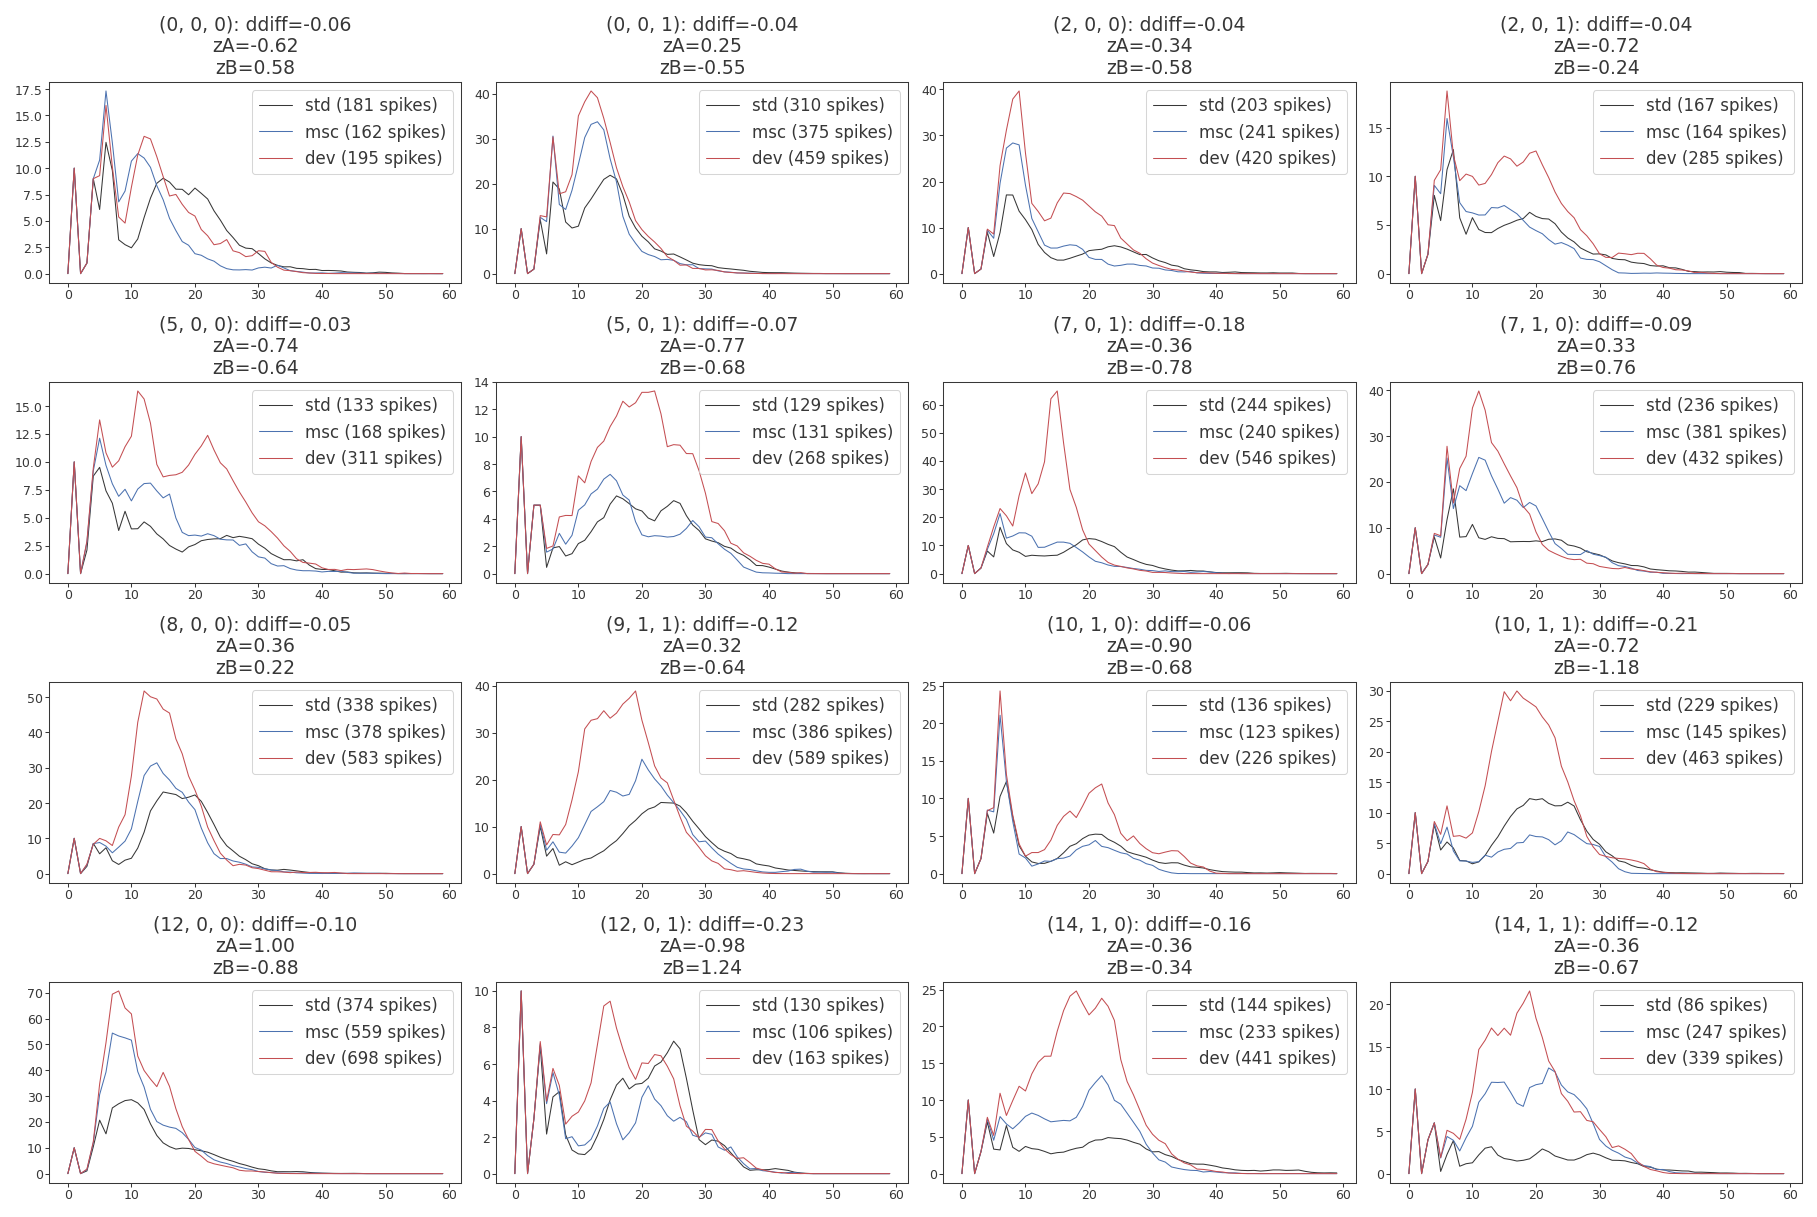

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(12,8), layout='constrained', dpi=150)
tmax = 60
for k, ax in zip(np.flatnonzero(preselection), axs.flatten()):
    for cond in conds:
        pspike = histograms['pspike'][ii.getindex(cfg, **q2, templ=0, cond=cond)].sum(-2).reshape(len(preselection), -1)[k, :tmax]
        ax.plot(pspike, color=pu.colors[cond], label=f'{cond} ({pspike.sum():.0f} spikes)')
    ax.legend()

    ax.set_title(f'{numbers[k]}: ddiff={ddiff[k]:.2f}\n'
                 f'zA={stats.zscore(response2["msc"].flatten()).flatten()[k]:.2f}\n'
                 f'zB={stats.zscore(np.flip(response2["msc"],2)).flatten()[k]:.2f}')

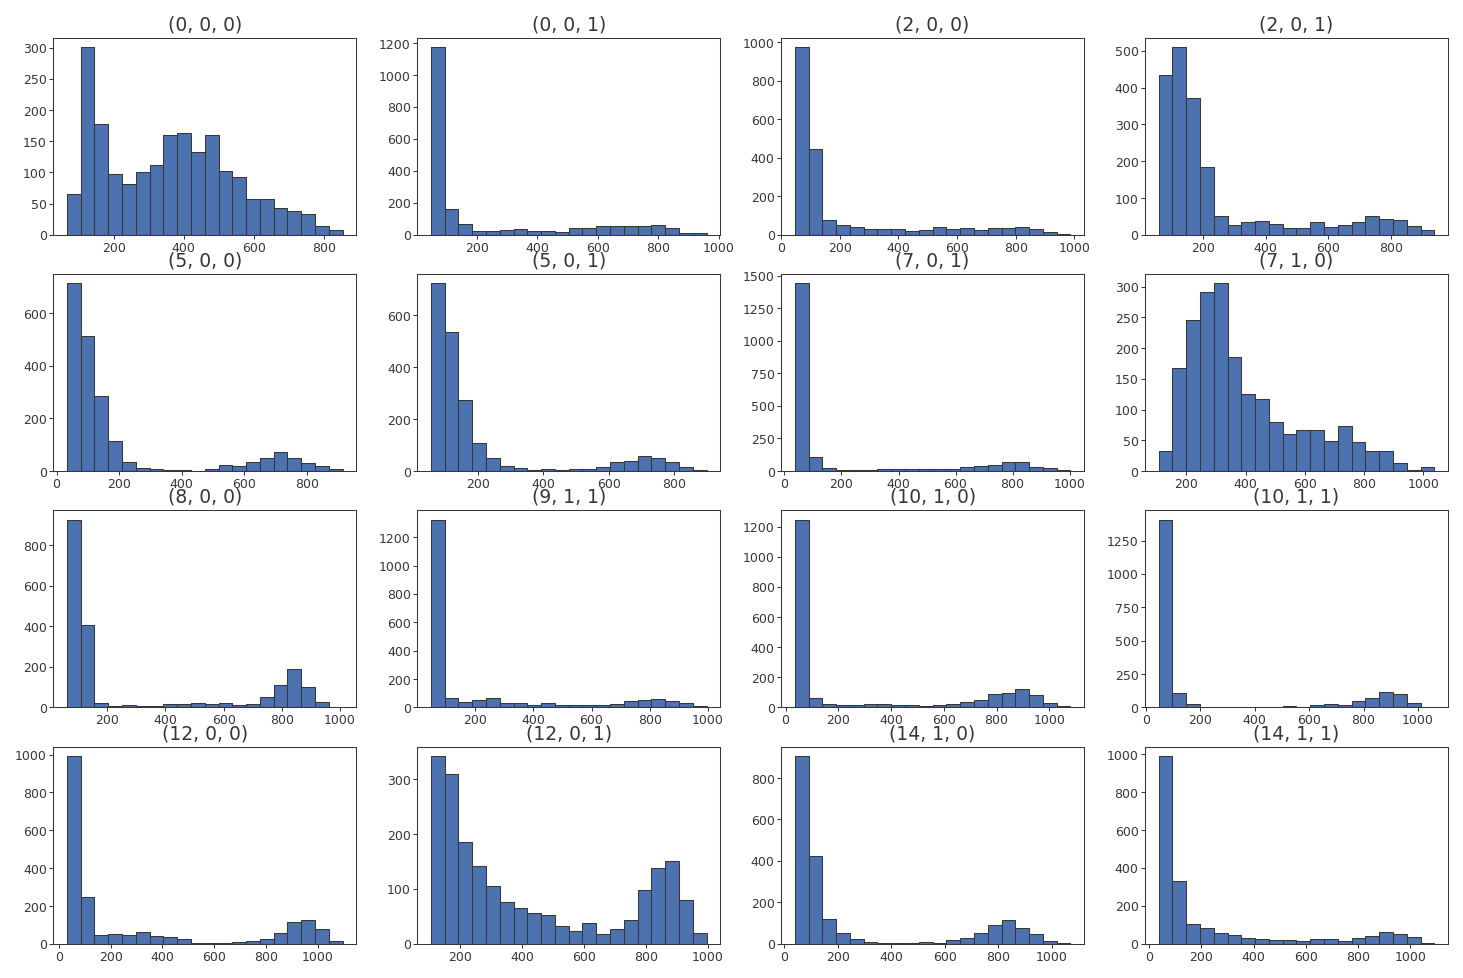

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(12,8), dpi=150)
for k, ax in zip(np.flatnonzero(preselection), axs.flatten()):
    net, ipair, istim = numbers[k]
    ax.hist(nspikes['std'][idx][:, net, ipair, 1-istim].sum(-1).flatten(), bins=20)
    ax.set_title(numbers[k])

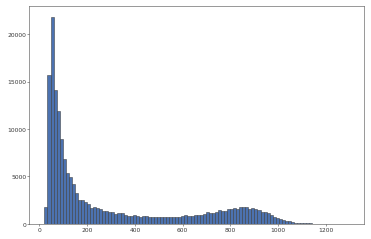

In [18]:
plt.hist(nspikes['std'][idx].sum(-1)[..., 100:].flatten(), bins=100);

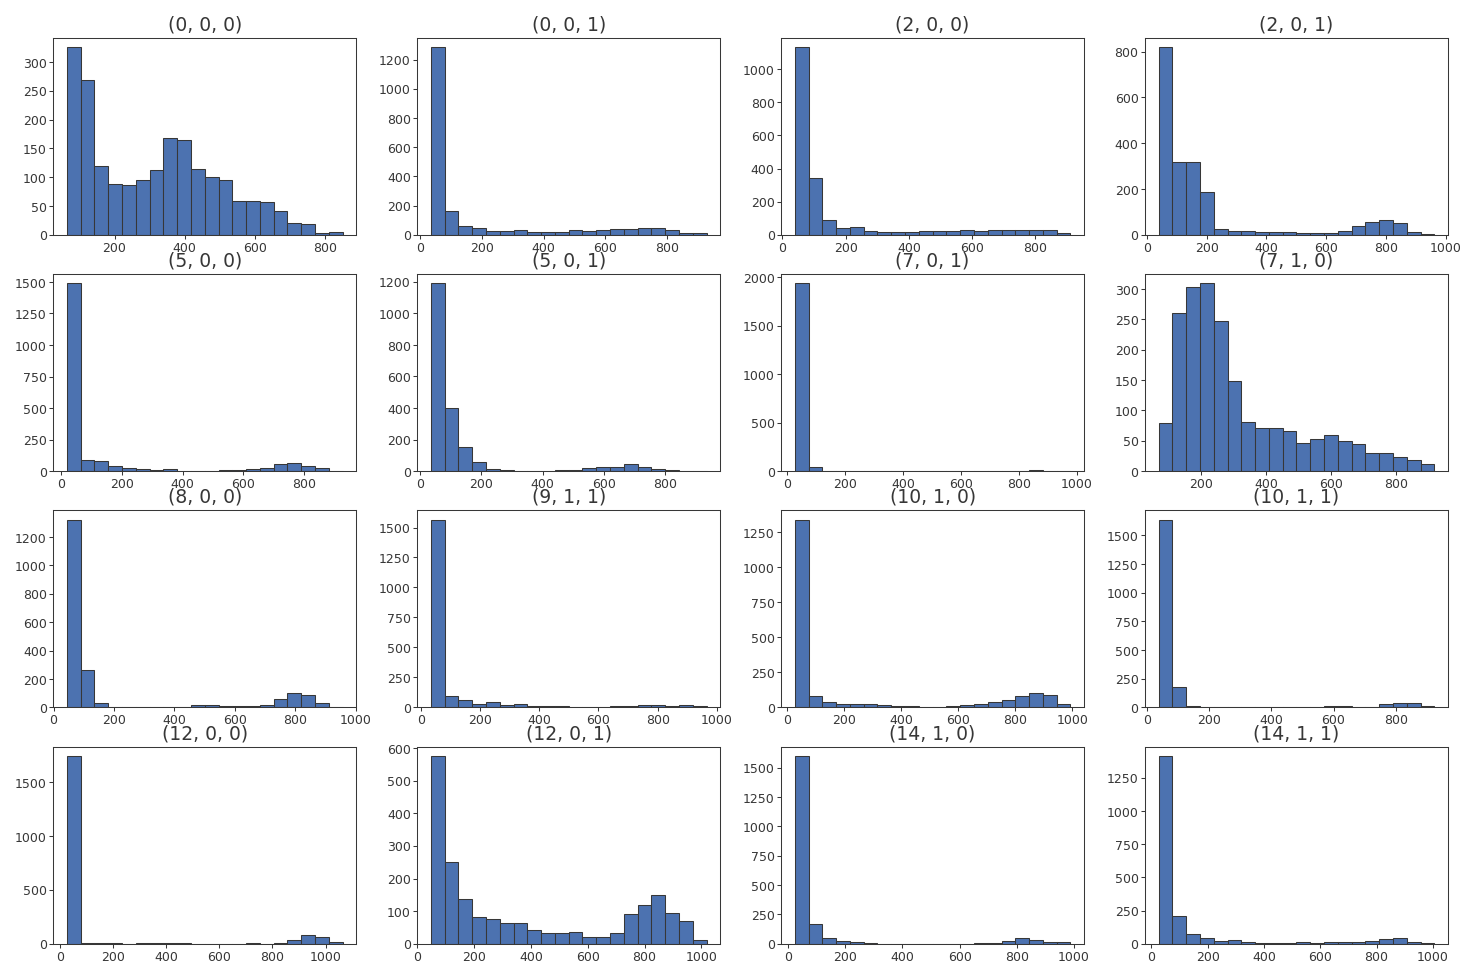

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(12,8), dpi=150)
for k, ax in zip(np.flatnonzero(preselection), axs.flatten()):
    net, ipair, istim = numbers[k]
    ax.hist(nspikes['std'][idx2][:, net, ipair, 1-istim].sum(-1).flatten(), bins=20)
    ax.set_title(numbers[k])

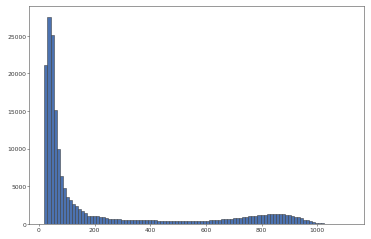

In [20]:
plt.hist(nspikes['std'][idx2].sum(-1)[..., 100:].flatten(), bins=100);

Ooh, looks like a lot of networks have a small number of large standard responses during steady state.